# Code for generating random redshifts
### Takes the measured redshift and mimics the distribution for the random catalog

## Make sure to change file paths and names as needed!!!!

In [1]:
%matplotlib inline
import os
import numpy as np
from astropy.io import fits as pf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
from astroML.density_estimation import EmpiricalDistribution
from astropy.cosmology import FlatLambdaCDM as FLCDM
from astropy import coordinates as coord
import astropy.units as u


In [2]:
#Read in the data and random catalogs
# file path
dpath = '../../data/QSO_Candidates_allcuts_with_errors_zcut45.fits'

rpath = '../../data/rand100x_kderf_samp.fits'

data=pf.open(dpath)[1].data
randdat = pf.open(rpath)[1].data


In [3]:
'''
#Implement cuts from Angular clustering
dx = ((data.ra>=344.1) | (data.ra < 330)) & (data.dec>=-1.5) & (data.dec<=1.5)  & (data.Ag<=0.21) & (data.zphotNW>=2.9) & (data.zphotNW<=5.4)
rdx = ((randdat.RA>=344.1) | (randdat.RA < 330)) & (randdat.DEC>=-1.5) & (randdat.DEC<=1.5)
#Define the first cut on the data in RA, DEC, Ag, and photoz
fdx = ((data.ra>=344.1) | (data.ra < 330))&  (data.Ag<=0.21) & (data.zphotNW>=2.9) & (data.zphotNW<=5.4)

#Include objects classified in 2/3 algortithms and generate imags
classification = (data.ypredBAG+data.ypredSVM+data.ypredRFC)
imag = 22.5-2.5*np.log10(data.iflux)
#The final classification
dx = ((data.zphotNW>=2.9) & (data.zphotNW<=5.4)) & ((fdx) |(classification <2)) #& (imag>20.2)
'''
dx = ()
datra = data.ra[dx]
datdec = data.dec[dx]
datz = data.zphotNW[dx]

#Random cut (No random cut needed for the above data cuts)
rdx = ()
randra = randdat.RA[rdx]
randdec= randdat.DEC[rdx]


print len(data.ra[dx])
print len(randdat.RA[rdx])
factor=len(randra)/float(len(datz))
print factor

8945
300000
33.5382895472


In [4]:
#Compute the optimal bin width (and number) using the Freedman-Diaconis rule 
q75, q25 = np.percentile(datz, [75 ,25])
iqr = q75 - q25
FDrule = 2* iqr / (float(len(datz))**(1/3.0))
bnum = round((max(datz)-min(datz))/FDrule)

print FDrule

bins=np.linspace(min(datz),max(datz),bnum)
binsmid = bins[:-1] + np.diff(bins)/2. #find the center of the bins

bin=np.linspace(min(datz),max(datz),len(bins))#*factor)
binmid = bin[:-1] + np.diff(bin)/2. #find the center of the bins

randsz = EmpiricalDistribution(datz).rvs(len(datz)*factor)
print len(randsz)

#dat,xd = np.histogram(data.zphotbest[gdx], bins=bins)
dat,xd = np.histogram(datz, bins=bins)
rand,xr = np.histogram(randsz, bins=bin)


0.0540347207706
300000


/Users/johntimlin/anaconda/lib/python2.7/site-packages/astroML/density_estimation/empirical.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = np.random.random(shape)


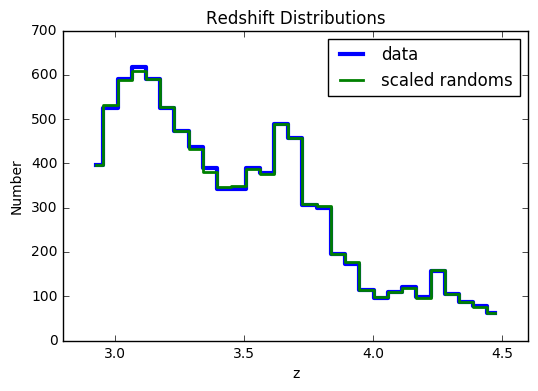

In [5]:
plt.figure(1)
plt.title('Redshift Distributions')
plt.plot(binsmid,dat,linestyle='steps-mid',label='data', linewidth=3)
plt.plot(binmid,rand/factor,linestyle='steps-mid',label='scaled randoms',linewidth=2)
plt.xlabel('z')
plt.ylabel('Number')
plt.legend()
plt.show()

In [6]:
#Setup the random set columns
RA=np.array(randra)
DEC=np.array(randdec)
Z=np.array(randsz)
print len(RA), len(DEC), len(Z)


300000 300000 300000


In [7]:
#Generate a table with the random columns

tbhdu=pf.BinTableHDU.from_columns([pf.Column(name='RA',format='D',array=RA),
pf.Column(name='DEC',format='D',array=DEC),
pf.Column(name='Z',format='D',array=Z)])

prihdr=pf.Header()
prihdr['COMMENT']="300,000 random points in the SpIES dual-band footprint"
prihdu=pf.PrimaryHDU(header=prihdr)

hdulist=pf.HDUList([prihdu,tbhdu])
#hdulist.writeto('../Randoms_with_redshifts.fits')

# Convert the randoms and data into cartesian x,y,z and generate table

In [8]:
#separate RA, DEC, Z for randoms and data

obsra=datra
obsdec=datdec
obsz=datz

randra=RA
randdec=DEC
randz=Z

In [9]:
#Convert redshift to Mpc
#Use the Planck2015 Cosmology of H0=70, omegaM = 0.274
#In physical density we have O_bary = 0.0223 and O_DM = 0.1188 and the conversion is
# O_matter = (O_bary+O_DM)/((H0/100)^2)
slaqcosmo=FLCDM(70,0.274,2.725)
obsX=slaqcosmo.comoving_distance(obsz)
randX=slaqcosmo.comoving_distance(randz)


In [24]:
#Convert RA/DEC to cartesian coords
cutcoord=coord.SkyCoord(ra=obsra*u.degree,dec=obsdec*u.degree, distance=obsX,frame='icrs')
randcoord=coord.SkyCoord(ra=randra*u.degree,dec=randdec*u.degree, distance=randX,frame='icrs')
cx=cutcoord.cartesian.x
cy=cutcoord.cartesian.y
cz=cutcoord.cartesian.z
rx=randcoord.cartesian.x
ry=randcoord.cartesian.y
rz=randcoord.cartesian.z

In [17]:
#Write to a file
tbhdu=pf.BinTableHDU.from_columns([pf.Column(name='datx',format='D',array=cx),
pf.Column(name='daty',format='D',array=cy),pf.Column(name='datz',format='D',array=cz),pf.Column(name='randx',format='D',array=rx),
pf.Column(name='randy',format='D',array=ry), pf.Column(name='randz',format='D',array=rz)])

prihdr=pf.Header()
prihdr['COMMENT']="Catalog of high redshift quasar candidates in the SpIES field"
prihdu=pf.PrimaryHDU(header=prihdr)

hdulist=pf.HDUList([prihdu,tbhdu])
#hdulist.writeto('QSO_candidates_highz_cartesian_werr_zcut45.fits')